---
layout: page
title: Interest Rates
---

In [1]:
""" import library and package dependencies """
import sys
sys.path.insert(0, '../src')
import os
import datetime
import pytz
from collections import namedtuple
from urllib.parse import quote
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from IPython.display import display, Markdown

from data_loader import load_csv_data, get_last_publish_date
from chart_format import StandardChart, PercentileChart
from data_functions import Percentiles

The Housing Loan Lending Rates are set by the Reserve Bank of Australia and published monthly within five business days after month end.

In [2]:
""" Load data 
RBA monthly home lending rates from 1959
https://www.rba.gov.au/statistics/tables/frequency-statistical-releases.html
Rates are published around 11:30am 5 business days after the end of the month
"""
publish_date = pd.Timestamp.now() + pd.offsets.MonthBegin(-1) + pd.offsets.BDay(5)

csv_url = 'https://www.rba.gov.au/statistics/tables/csv/f5-data.csv'
local_file = '../data/f5-data.csv'

# First 10 rows are descriptive header rows
skip_rows = 10

df = load_csv_data(local_file, csv_url, publish_date, skip_rows)

In [3]:
""" Data Transformation """
df.dropna(subset=['Series ID'], inplace=True)

# FILRHLBVS = Financial Interest; Lending rates; Housing loans; Banks; Variable; Standard; Owner-occupier
data_column = 'FILRHLBVS'

# Series ID dates are in the format 'Jan-1959' %b-%Y
df['Date'] = df['Series ID'].apply(lambda d: pd.to_datetime(d, format='%b-%Y') + pd.offsets.MonthEnd(1))
df.set_index('Date', inplace=True)

last_index = df[data_column].last_valid_index()
# only include rows up to the last_index (drop the NaN rows at end of file)
df = df.loc[:last_index]


Australian interest rates ramped up from 6% in 1970 to a peak 17% in 1990 before dropping sharply back down to 10% in 1992.

Interest rates remained reasonably volatile with some sharp spikes and sudden drops, but overall trended down to 5% in 2020, before spiking back over 8% in 2023.

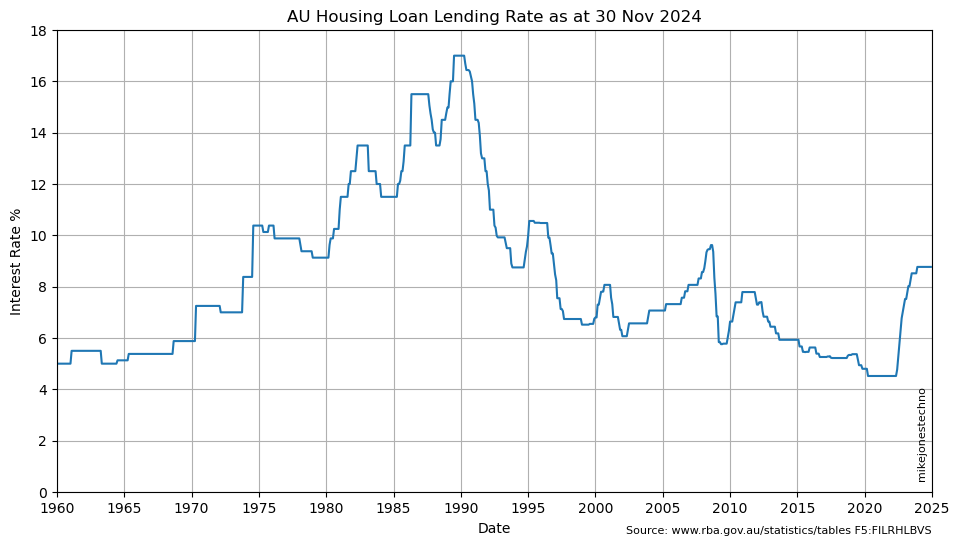

In [4]:
""" Show simple chart """

chart_params = {
    'chart_title': 'AU Housing Loan Lending Rate as at ' + last_index.strftime('%d %b %Y'), 
    'chart_source': 'Source: www.rba.gov.au/statistics/tables F5:' + data_column, 
    'y_label': 'Interest Rate %', 
    'y_ticks': 2,
    'x_label': 'Date', 
    'x_ticks': 5,
    'start_year': 1960,
    'data_column': data_column
}

standard_chart = StandardChart(**chart_params)
plt, colors = standard_chart.base_chart(df)

plt.plot(df.index, df[data_column], color=colors[0]['color'])

plt.show()

In [5]:
""" Calculate and print percentiles table """
periods_per_year = 12
percentiles = Percentiles(df, data_column, periods_per_year)
df = percentiles.calculate_percentiles(df)
df_last_percentiles = percentiles.calculate_last_percentiles(df)

In [6]:
percentiles.display_percentile_intro()


Calculating the 25th and 75th percentile over a multi year time horizon helps smooth out the anomolies and visualize the lower and upper long term trends.
    

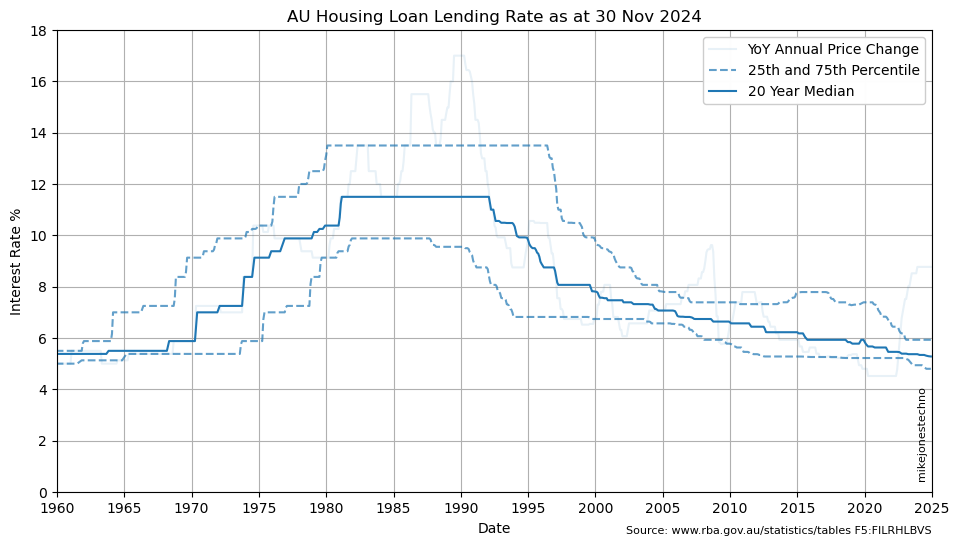

In [7]:
chart_params['color_index'] = 0
chart_params['legend_location'] = 'best'
percentile_chart = PercentileChart(percentiles.percentiles, percentiles.multi_years[3], **chart_params)
plt = percentile_chart.plot_percentiles(df) 
plt.show()

In [8]:
percentiles.display_percentile_summary(df_last_percentiles, 'interest rate')
percentiles.display_dataframe_table(df_last_percentiles)


Over the last 5 years the median (50th percetile) interest rate is 5.04%; The mean (average) interest rate is 6.31%.

Over the last 30 years the median (50th percetile) interest rate is 6.74%; The mean (average) interest rate is 6.87%.
    

Years,25th percentile,50th percentile,75th percentile,mean
1,8.77,8.77,8.77,8.77
5,4.52,5.04,8.52,6.31
10,4.80,5.28,5.81,5.83
20,5.28,6.22,7.77,6.52
30,5.76,6.74,7.79,6.87


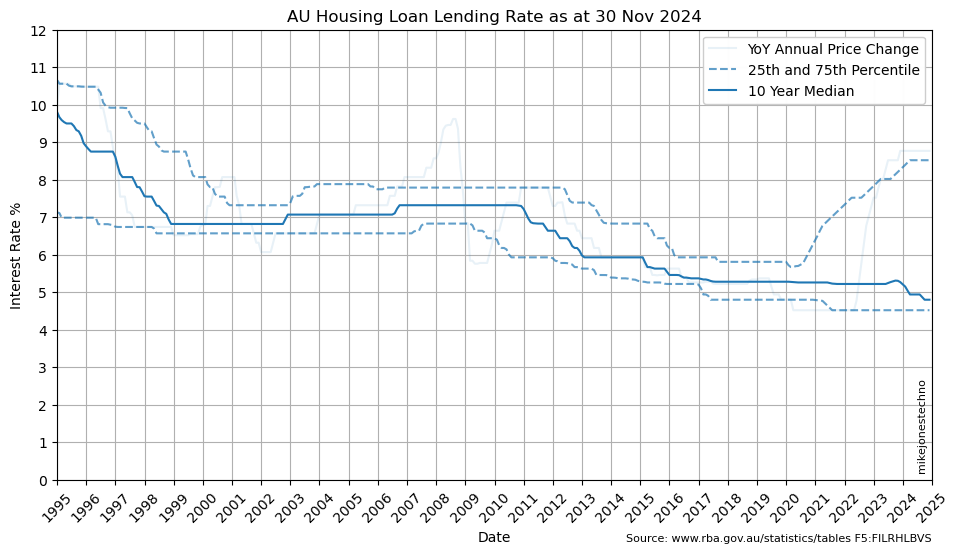

In [9]:
""" Change chart variables to plot from 1995"""

chart_params['start_year'] = 1995
chart_params['end_year'] = 2025 # set end year to multiple of old x_ticks before we change to 1 year ticks.
chart_params['y_ticks'] = 1
chart_params['x_ticks'] = 1
chart_params['top_limit'] = 12
chart_params['legend_location'] = 'upper right'

percentile_chart = PercentileChart(percentiles.percentiles, percentiles.multi_years[2], **chart_params)
plt = percentile_chart.plot_percentiles(df)
plt.show()

The chart shows interst rates have trended down from 7% to below 5% over the last 20 years.

> ℹ The data suggests reasonable confidence using baseline interest rates around 6% with reasonable uncertainty or risk that interest rates could peak higher.

In [10]:
%%capture
# Magic store dataframe to share with combo notebook
df_interest = df
%store df_interest